<a href="https://colab.research.google.com/github/thpablo/CRUD_bd/blob/main/TP_NaoLinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# --------------------------
# Dataset and Model
# --------------------------
def get_mnist_dataloader(batch_size=64):
    # Load MNIST dataset and wrap it in a DataLoader
    transform = transforms.ToTensor()  # convert images to tensors
    dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader, dataset


In [ ]:
def create_model():
    # Define a simple 2-layer MLP with ReLU activation
    return nn.Sequential(
        nn.Flatten(),                     # flatten image to vector
        nn.Linear(784, 128), nn.ReLU(),  # hidden layer
        nn.Linear(128, 10)               # output layer (10 classes)
    )


# --------------------------
# Training
# --------------------------
def train_model(model, dataloader, device, epochs=1, lr=1e-3):
    # Basic model training loop
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    losses = []
    for epoch in range(epochs):
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(images), labels)
            losses.append(loss.item())
            loss.backward()
            # Cliping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    return losses

In [ ]:
# --------------------------
# Gradient Leakage Simulation
# --------------------------
def sample_single(dataset, device):
    # Randomly select one (image, label) pair
    x, y = random.choice(dataset)
    x = x.unsqueeze(0).to(device)  # add batch dimension
    y = torch.tensor([y], device=device)
    return x, y

def sample_batch(dataset, batch_size, device):
    # Sample a batch of images from dataset
    indices = random.sample(range(len(dataset)), batch_size)
    xs, ys = zip(*[dataset[i] for i in indices])
    xs = torch.stack(xs).to(device)
    ys = torch.tensor(ys, device=device)
    return xs, ys

def compute_gradient(model, x, y, reduction='mean'):
    # Compute gradient of loss w.r.t model parameters
    model.eval()
    loss_fn = nn.CrossEntropyLoss(reduction=reduction)
    loss = loss_fn(model(x), y)
    grads = torch.autograd.grad(loss, model.parameters())
    return torch.cat([g.detach().view(-1) for g in grads])  # flatten all gradients into one vector

# --------------------------
# Reconstruction
# --------------------------
def reconstruct_single(model, g_star, lambda_reg=1e-4, iters=300, lr=0.1, seed=0, device='cpu', optimizer='adam'):
    import torch
    import torch.optim as optim

    torch.manual_seed(seed)
    x_hat = torch.rand(1, 1, 28, 28, requires_grad=True, device=device)
    y_logits = torch.zeros(1, 10, requires_grad=True, device=device)

    loss_trace = []

    # Utilizando Adam
    if optimizer == 'adam':
        optimizer = optim.Adam([x_hat, y_logits], lr=lr)

        def closure():
            optimizer.zero_grad()
            y_prob = y_logits.softmax(dim=-1)
            loss = (model(x_hat) * y_prob).sum()
            grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
            grad_diff = torch.cat([g.view(-1) for g in grads]) - g_star
            obj = grad_diff.pow(2).sum() + lambda_reg * x_hat.pow(2).sum()
            obj.backward()
            # Clipping
            torch.nn.utils.clip_grad_norm_([x_hat], max_norm=1.0)
            loss_trace.append(obj.item())
            return obj

        for _ in range(iters):
            optimizer.step(closure)

    # Utilizando LBFGS
    elif optimizer.lower() == 'lbfgs':
        optimizer = optim.LBFGS([x_hat, y_logits], lr=lr, max_iter=iters)

        def closure():
            optimizer.zero_grad()
            y_prob = y_logits.softmax(dim=-1)
            loss = (model(x_hat) * y_prob).sum()
            grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
            grad_diff = torch.cat([g.view(-1) for g in grads]) - g_star
            obj = grad_diff.pow(2).sum() + lambda_reg * x_hat.pow(2).sum()
            obj.backward()
            # Clipping
            torch.nn.utils.clip_grad_norm_([x_hat], max_norm=1.0)
            loss_trace.append(obj.item())
            return obj

        optimizer.step(closure)

    else:
        raise ValueError("Optimizer not supported")

    predicted_label = y_logits.argmax(dim=-1).item()
    return x_hat.detach().cpu(), predicted_label, loss_trace


def reconstruct_batch(model, g_star, batch_size, lambda_reg=1e-4, iters=300, lr=0.1, seed=0, device='cpu'):
    # Reconstruct a batch of images and labels from gradient
    torch.manual_seed(seed)
    x_hat = torch.rand(batch_size, 1, 28, 28, requires_grad=True, device=device)
    y_logits = torch.zeros(batch_size, 10, requires_grad=True, device=device)
    optimizer = optim.LBFGS([x_hat, y_logits], lr=lr, max_iter=20)

    loss_trace = []

    def closure():
        optimizer.zero_grad()
        y_prob = y_logits.softmax(dim=-1)
        loss = (model(x_hat) * y_prob).sum()
        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        grad_diff = torch.cat([g.view(-1) for g in grads]) - g_star
        obj = grad_diff.pow(2).sum() + lambda_reg * x_hat.pow(2).sum()
        obj.backward()
        loss_trace.append(obj.item())
        return obj

    for _ in range(iters):
        optimizer.step(closure)

    predicted_labels = y_logits.argmax(dim=-1).cpu().tolist()
    return x_hat.detach().cpu(), predicted_labels, loss_trace

# --------------------------
# Evaluation and Visualization
# --------------------------
def plot_reconstruction(x_gt, x_recon, title):
    # Visual comparison between ground truth and reconstructed image
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(x_gt.squeeze().numpy(), cmap='gray')
    axes[0].set_title('Ground Truth')
    axes[1].imshow(x_recon.squeeze().numpy(), cmap='gray')
    axes[1].set_title('Reconstructed')
    fig.suptitle(title)
    plt.show()

def plot_loss(loss_trace):
    # Plot the loss trajectory during optimization
    plt.plot(loss_trace)
    plt.xlabel('Iteration')
    plt.ylabel('Objective Value')
    plt.title('Loss over Iterations')
    plt.grid(True)
    plt.show()

In [ ]:
# Baixa Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

dataloader, dataset = get_mnist_dataloader()

cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 36.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 994kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.27MB/s]


Epoch 1/1, Loss: 0.1125


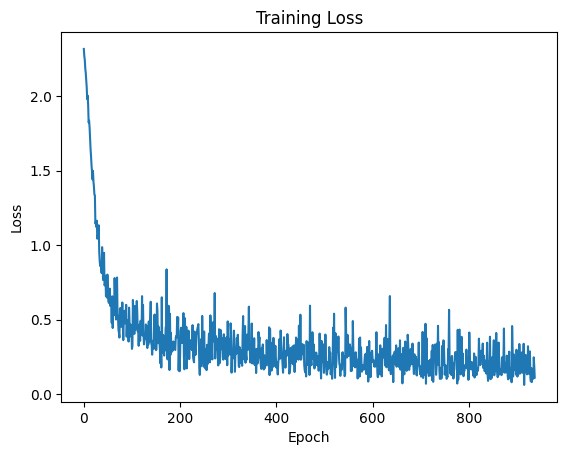

In [ ]:
# Treina modelo
model = create_model()
loss_history = train_model(model, dataloader, device)

# Plot the loss curve
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

[Single] True: 9, Reconstructed: 4


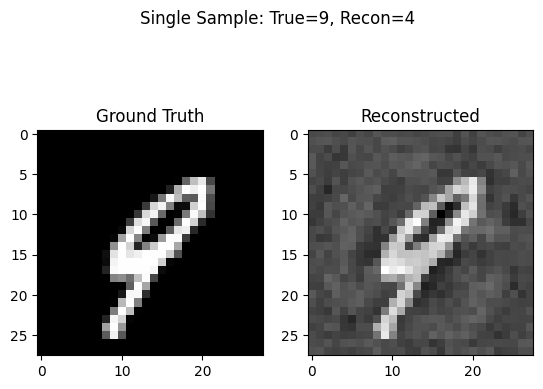

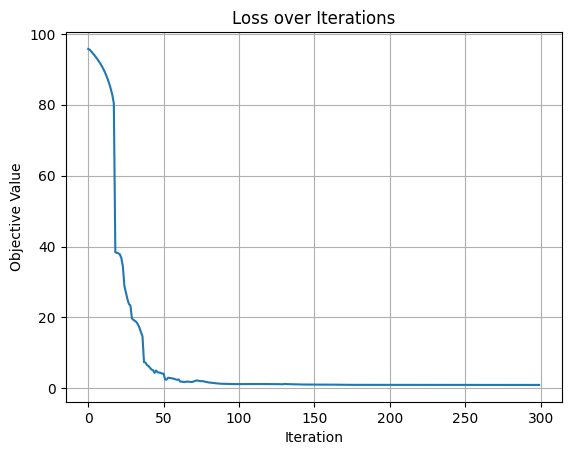

In [ ]:
# Single inversion example
x_gt, y_gt = sample_single(dataset, device)
g_star = compute_gradient(model, x_gt, y_gt)


# Normaliza g_star
g_star = g_star / (g_star.norm() + 1e-8)

best_loss = float('inf')
best_reconstruction = None

x_recon, y_recon, loss_trace = reconstruct_single(model, g_star, device=device, optimizer='LBFGS', lambda_reg=5e-3)

final_loss = loss_trace[-1]
if final_loss < best_loss:
  best_loss = final_loss
  best_reconstruction = (x_recon, y_recon, loss_trace)


print(f"[Single] True: {y_gt.item()}, Reconstructed: {y_recon}")
plot_reconstruction(x_gt.cpu(), x_recon, f"Single Sample: True={y_gt.item()}, Recon={y_recon}")
plot_loss(loss_trace)


In [ ]:
# Batch inversion example
x_batch, y_batch = sample_batch(dataset, 4, device)
g_star_batch = compute_gradient(model, x_batch, y_batch)
x_recon_batch, y_recon_batch, batch_loss_trace = reconstruct_batch(model, g_star_batch, 4, device=device)
print(f"[Batch] True: {y_batch.cpu().tolist()}, Reconstructed: {y_recon_batch}")

[Batch] True: [8, 0, 6, 6], Reconstructed: [6, 5, 1, 2]


# Testando Varios Valores de Lr e Lambda

## Codigo para plotar informacoes

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Quantidade de Exemplos
num_initializations = 5

# Função para plotar curva de perda e MSE
def plot_losses_and_mse(traces_adam, mses_adam, traces_lbfgs, mses_lbfgs, lamb, lr):
    num_plots = min(len(traces_adam), len(traces_lbfgs), num_initializations)
    fig, axs = plt.subplots(2, num_plots, figsize=(4 * num_plots, 8))
    fig.suptitle(f"Função Objetivo e MSE - lambda={lamb}, lr={lr}", fontsize=16)

    if num_plots == 1:
        axs = np.array([[axs[0]], [axs[1]]])

    for i in range(num_plots):
        # Adam
        axs[0, i].plot(traces_adam[i]['loss'], label='Adam - Loss', color='blue')
        axs[0, i].axhline(mses_adam[i], linestyle='--', color='red', label=f'MSE={mses_adam[i]:.4f}')
        final_loss_adam = traces_adam[i]['loss'][-1] if traces_adam[i]['loss'] else float('nan')
        axs[0, i].set_title(f'Init {i+1} - Adam\nFinal Loss={final_loss_adam:.4f}')
        axs[0, i].set_xlabel('Iterações')
        axs[0, i].set_ylabel('Loss')
        axs[0, i].legend()
        axs[0, i].grid(True)

        # LBFGS
        axs[1, i].plot(traces_lbfgs[i]['loss'], label='LBFGS - Loss', color='green')
        axs[1, i].axhline(mses_lbfgs[i], linestyle='--', color='red', label=f'MSE={mses_lbfgs[i]:.4f}')
        final_loss_lbfgs = traces_lbfgs[i]['loss'][-1] if traces_lbfgs[i]['loss'] else float('nan')
        axs[1, i].set_title(f'Init {i+1} - LBFGS\nFinal Loss={final_loss_lbfgs:.4f}')
        axs[1, i].set_xlabel('Iterações')
        axs[1, i].set_ylabel('Loss')
        axs[1, i].legend()
        axs[1, i].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Função para plotar melhor reconstrucao dentre as 5 inicializacoes
def plot_best_reconstructions(x_gt, traces_adam, mses_adam, traces_lbfgs, mses_lbfgs):
    import numpy as np
    import matplotlib.pyplot as plt

    mses_adam = np.array(mses_adam)
    mses_lbfgs = np.array(mses_lbfgs)

    # Garante nao plotar NaN
    valid_adam = np.where(~np.isnan(mses_adam))[0]
    valid_lbfgs = np.where(~np.isnan(mses_lbfgs))[0]

    best_idx_adam = valid_adam[np.argmin(mses_adam[valid_adam])] if len(valid_adam) > 0 else None
    best_idx_lbfgs = valid_lbfgs[np.argmin(mses_lbfgs[valid_lbfgs])] if len(valid_lbfgs) > 0 else None

    gt = x_gt.detach().cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(gt.squeeze(), cmap='afmhot')
    axs[0].set_title('Ground Truth')
    axs[0].axis('off')

    if best_idx_adam is not None:
        best_adam = traces_adam[best_idx_adam]['recon'].detach().cpu().numpy()
        axs[1].imshow(best_adam.squeeze(), cmap='afmhot')
        axs[1].set_title(f'Adam Recon (MSE={mses_adam[best_idx_adam]:.4f})')
    else:
        axs[1].set_title('Adam Recon (MSE=NaN)')
        axs[1].axis('off')

    if best_idx_lbfgs is not None:
        best_lbfgs = traces_lbfgs[best_idx_lbfgs]['recon'].detach().cpu().numpy()
        axs[2].imshow(best_lbfgs.squeeze(), cmap='afmhot')
        axs[2].set_title(f'LBFGS Recon (MSE={mses_lbfgs[best_idx_lbfgs]:.4f})')
    else:
        axs[2].set_title('LBFGS Recon (MSE=NaN)')
        axs[2].axis('off')

    plt.tight_layout()
    plt.show()

# Retorna melhor configuracao dentre todos resultados, com base no MSE
def get_best_configuration(all_results):
    """
    Recebe uma lista de dicionarios no formato:
    {
        'lambda': valor,
        'lr': valor,
        'optimizer': 'adam' ou 'lbfgs',
        'mse': valor do mse,
        'trace': lista de reconstrucoes,
        'x_gt': ground truth usado
    }
    Retorna o dicionario com menor MSE (ignorando NaNs)
    """
    import numpy as np

    valid_results = [r for r in all_results if not np.isnan(r['mse'])]

    if len(valid_results) == 0:
        return None  # nenhum resultado valido

    best_result = min(valid_results, key=lambda x: x['mse'])
    return best_result



## Codigo para retirar exemplo de gradiente e realizar calculo

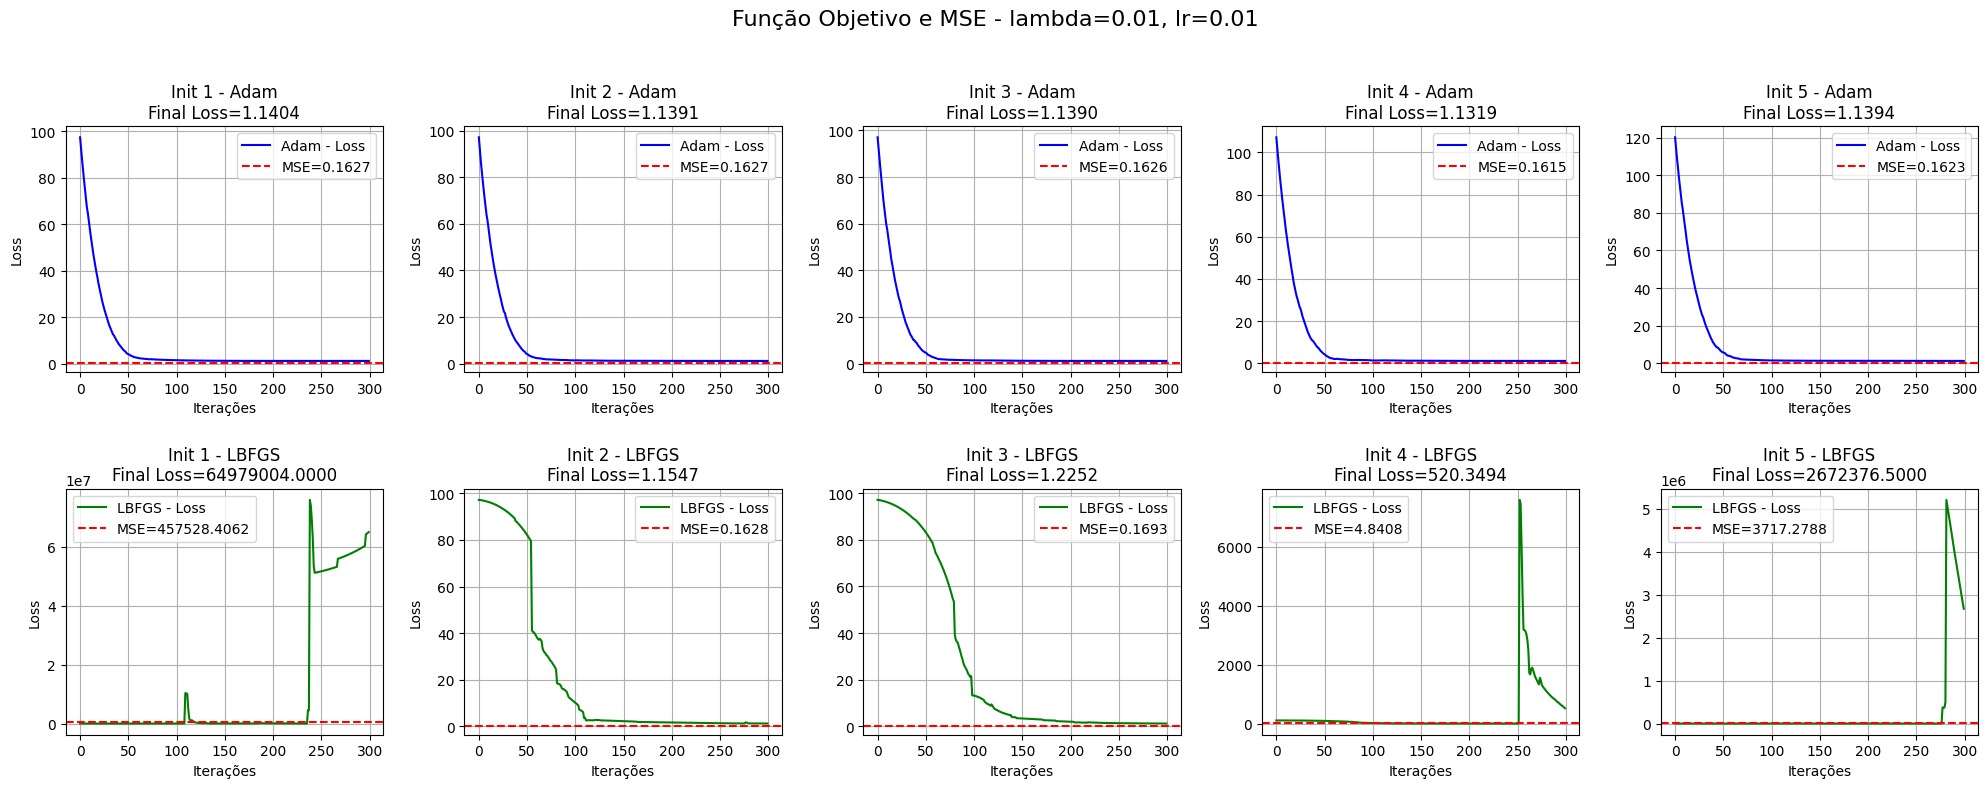

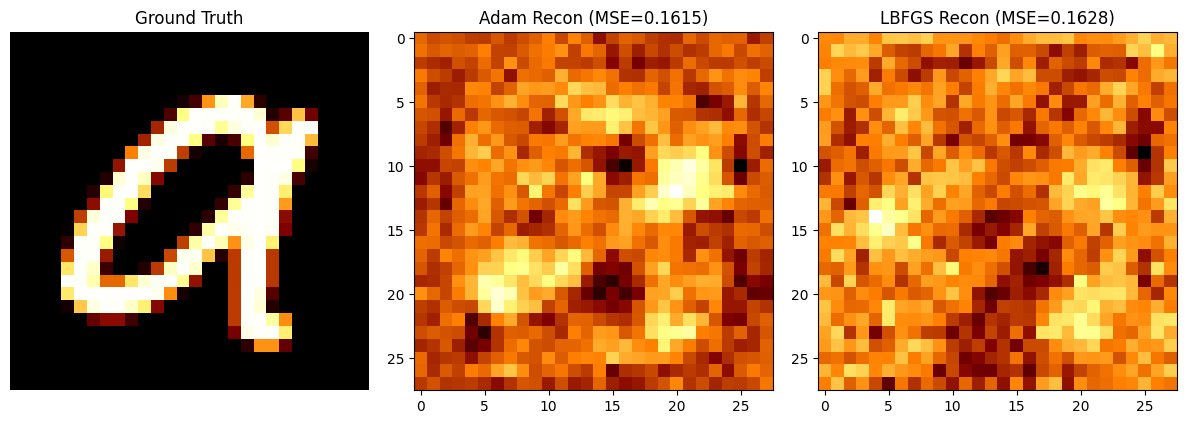

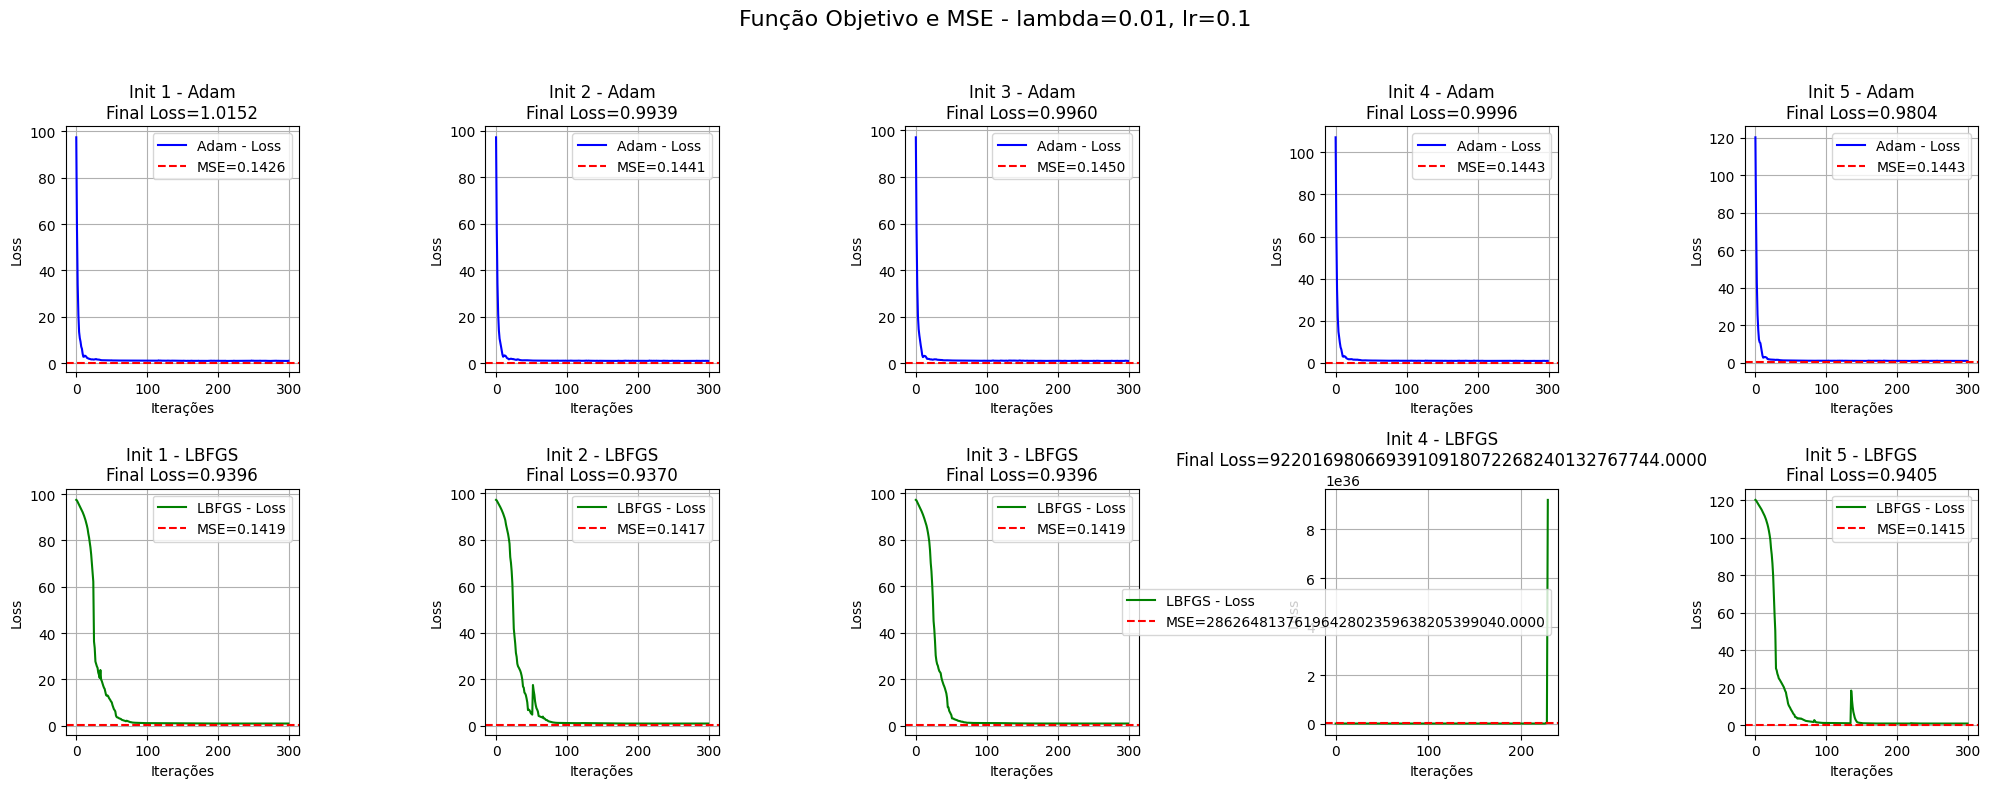

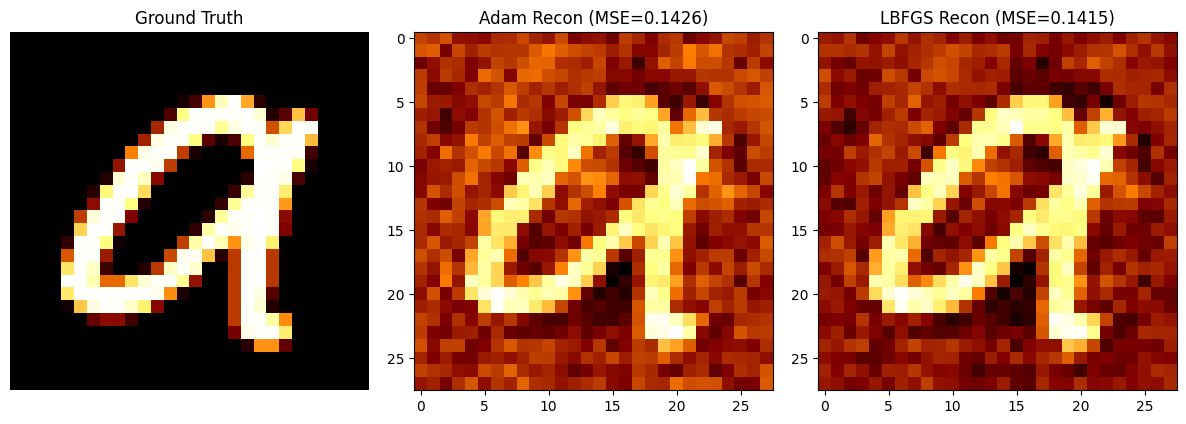

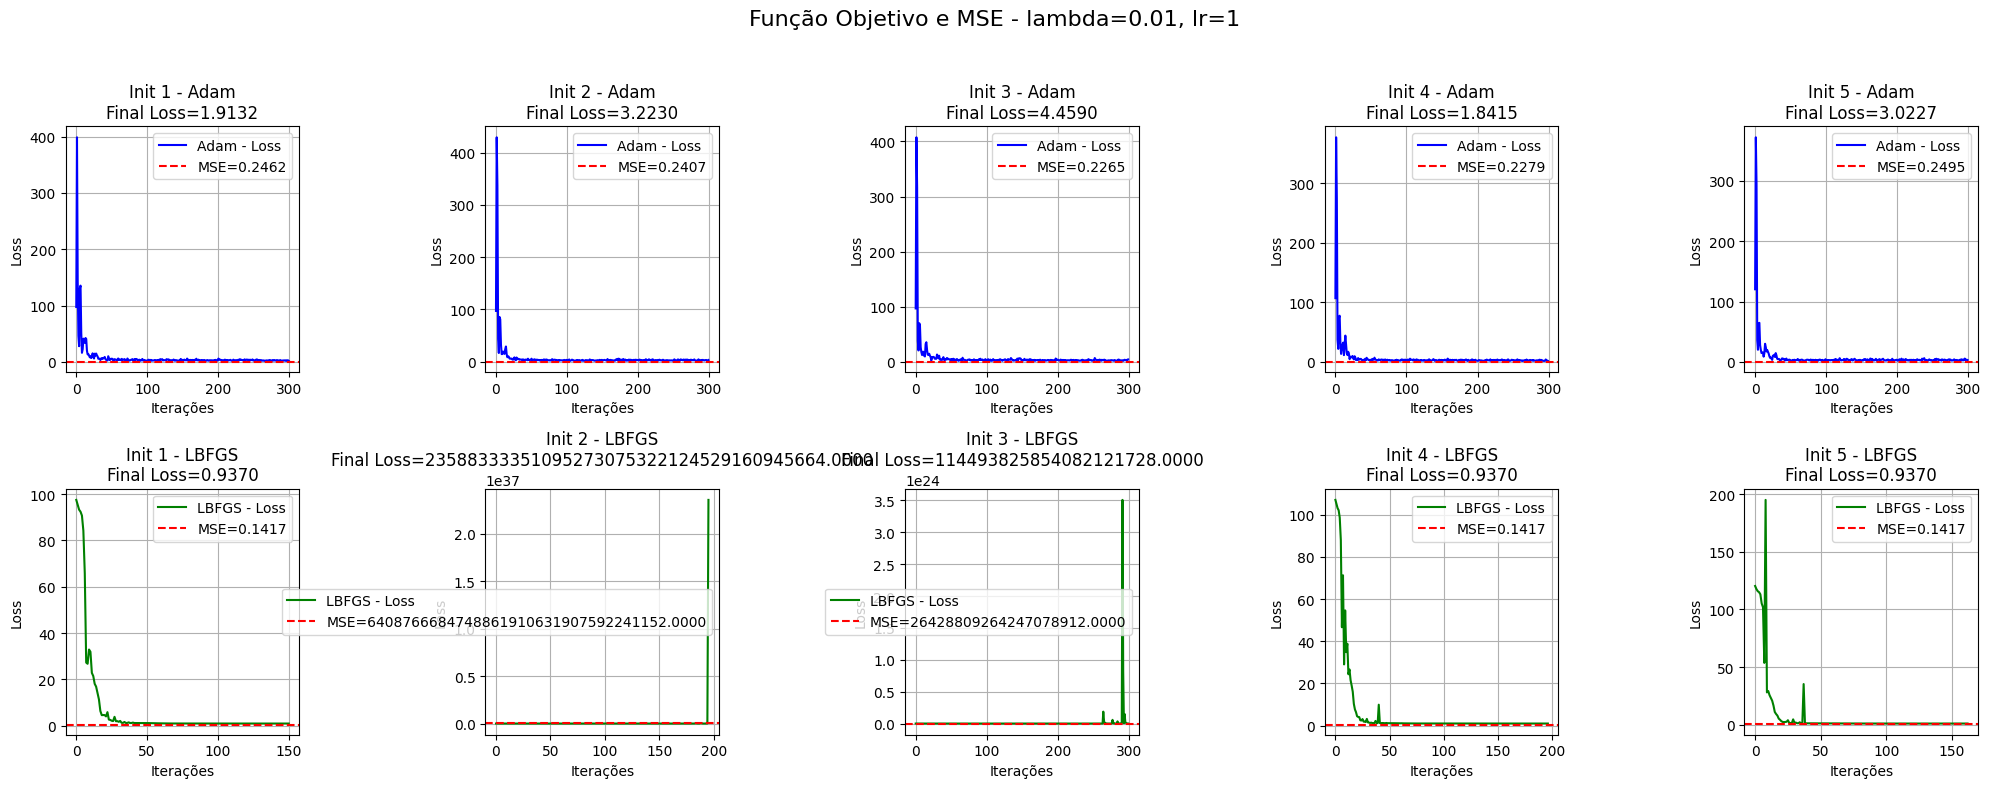

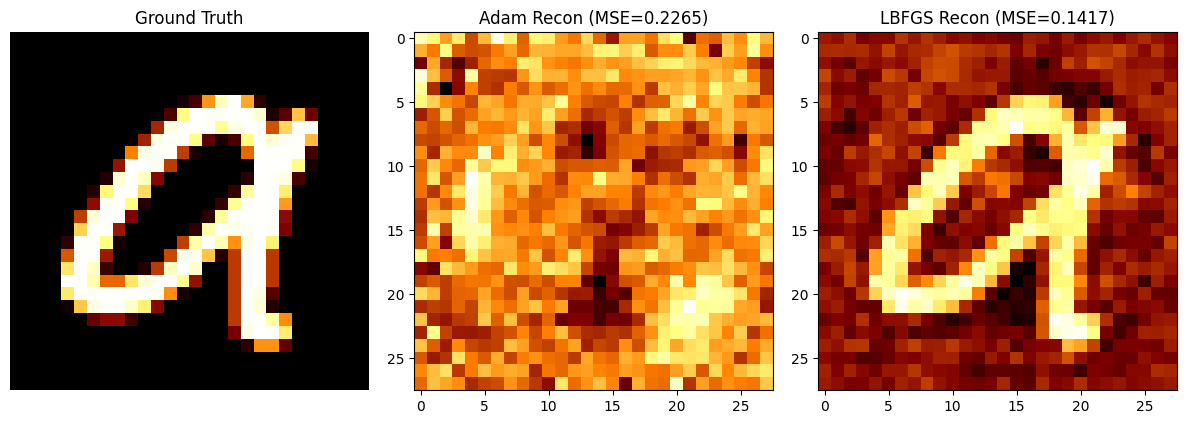

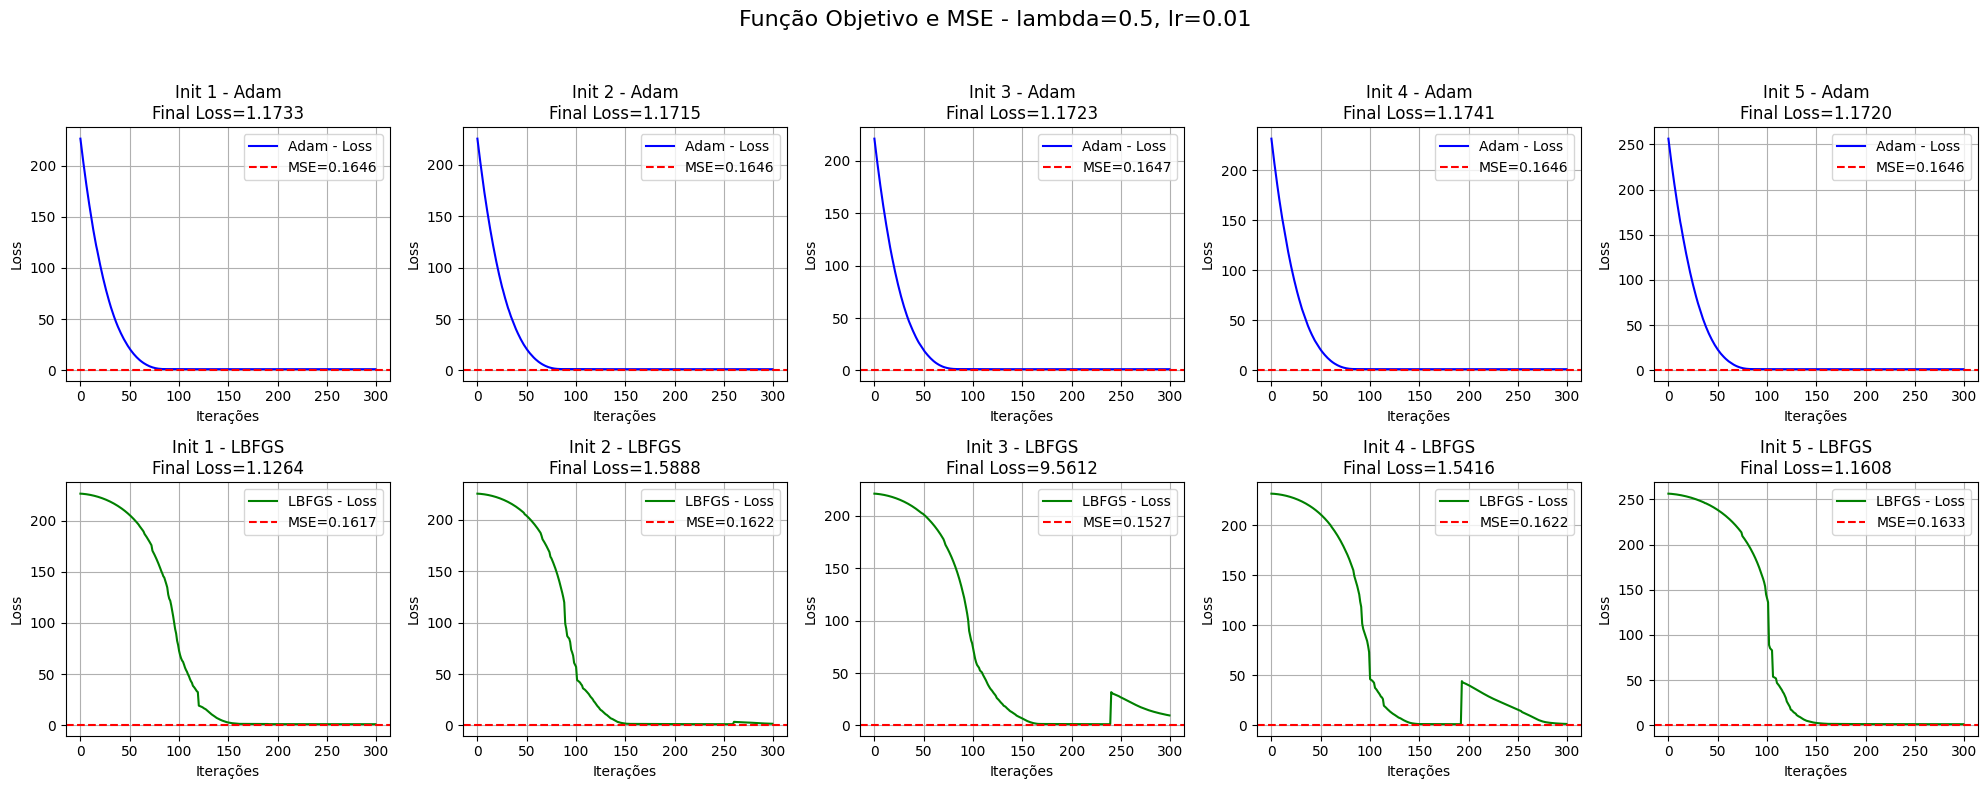

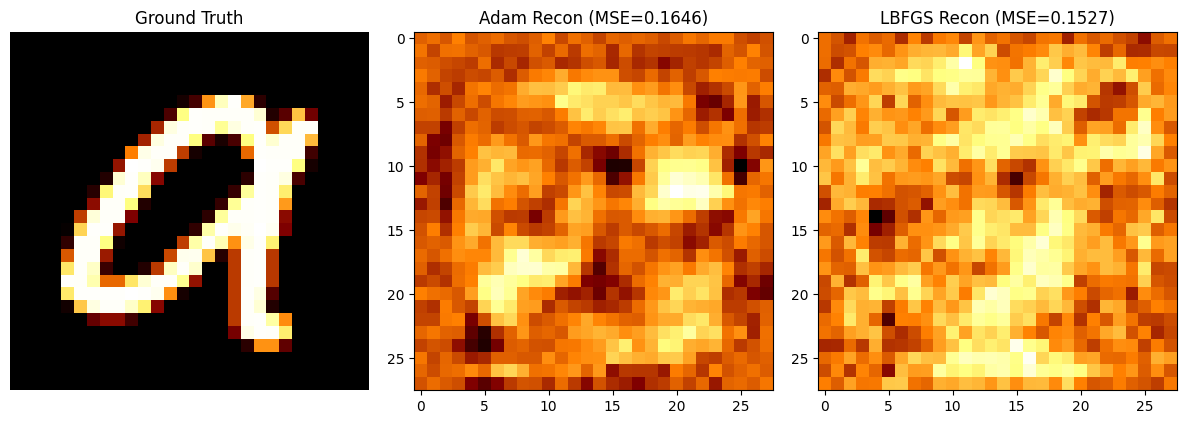

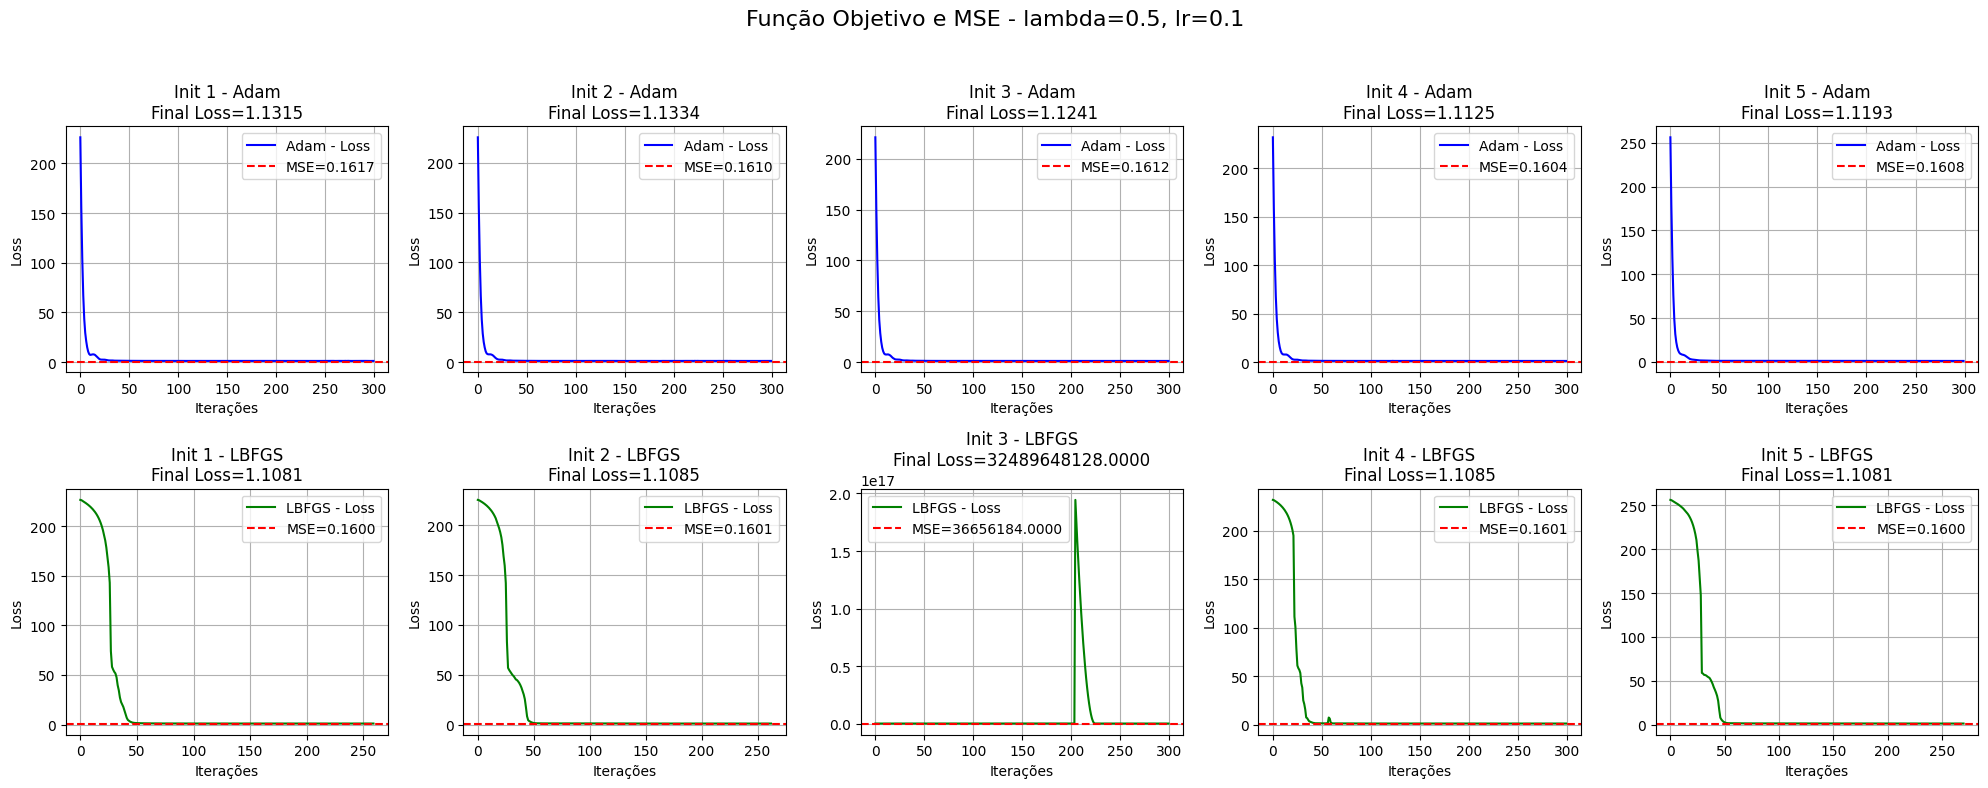

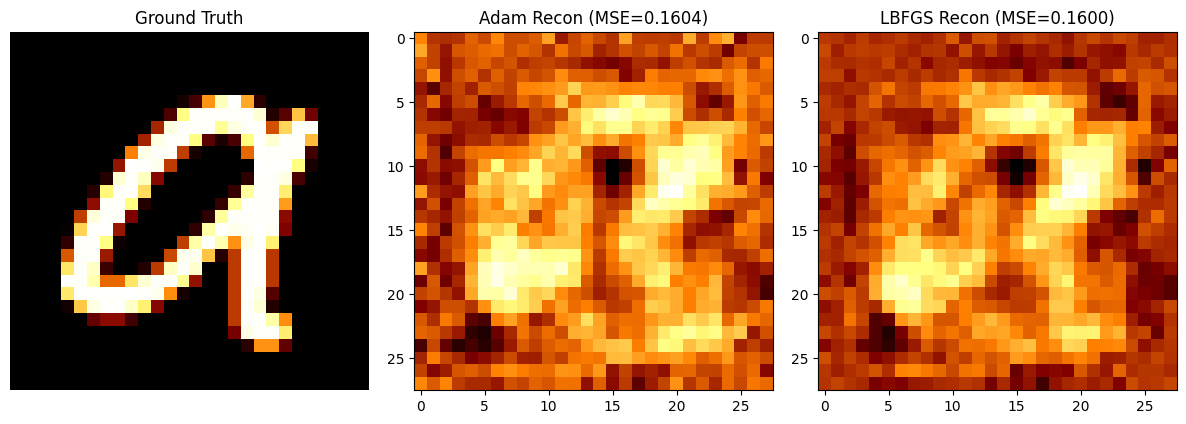

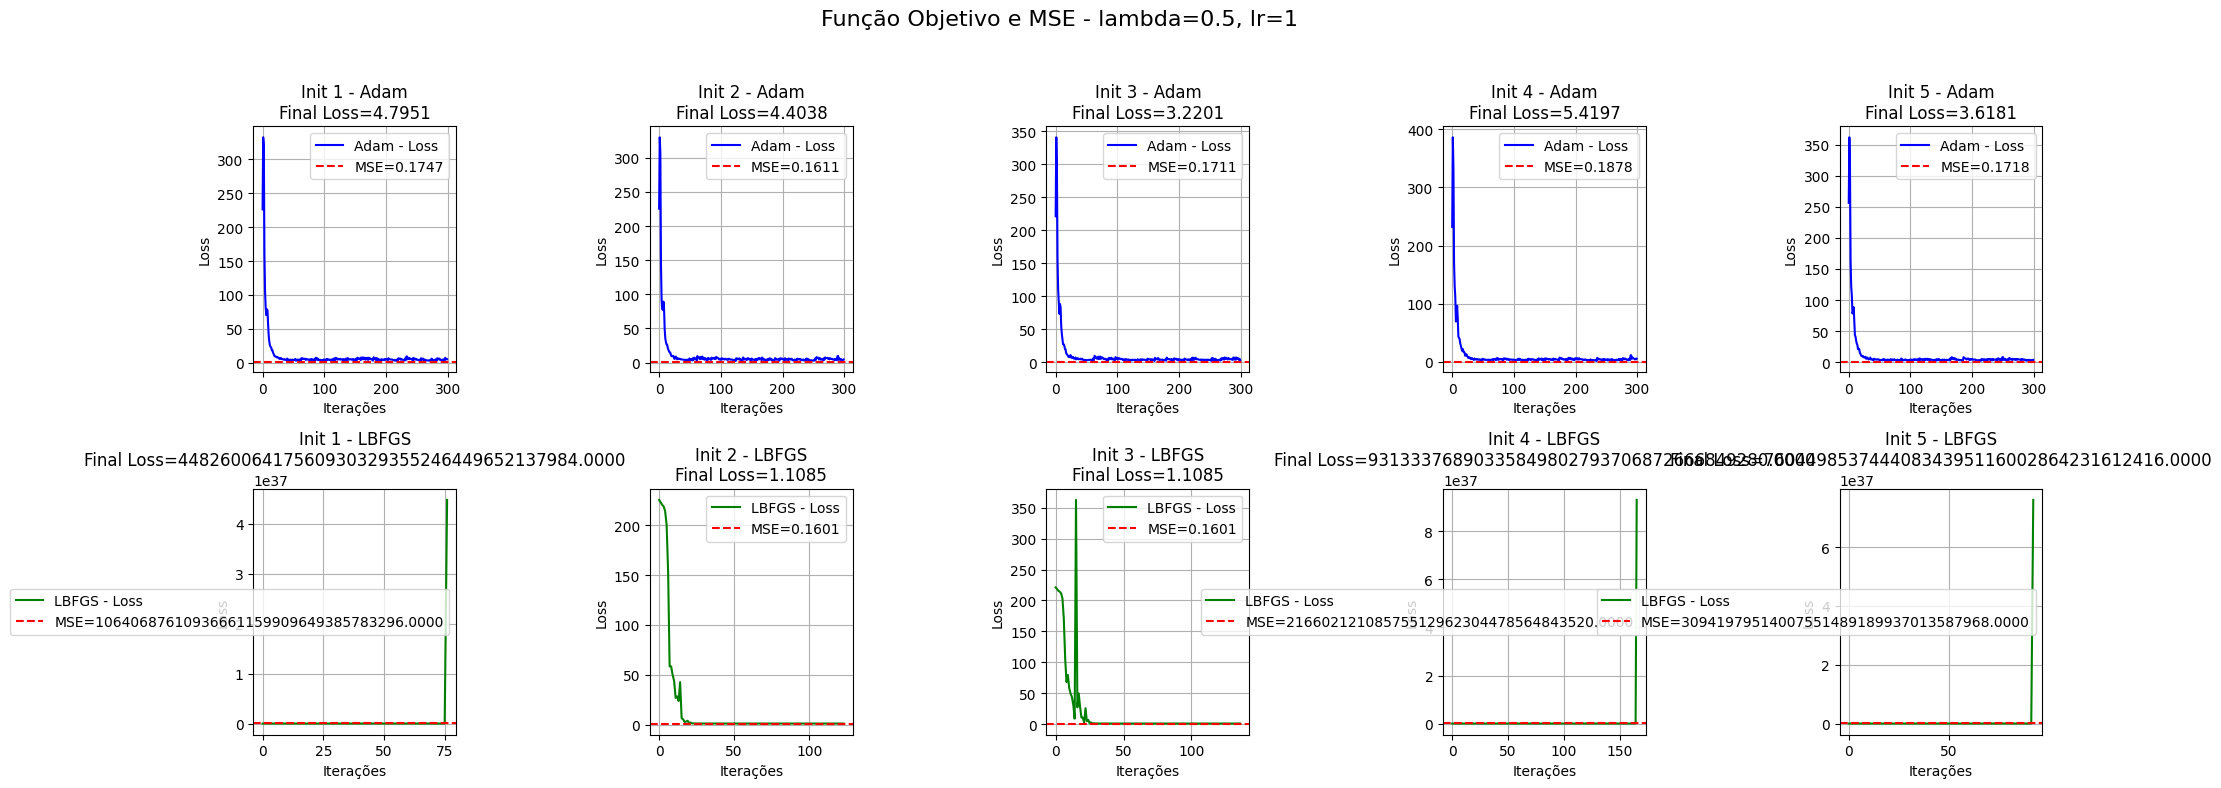

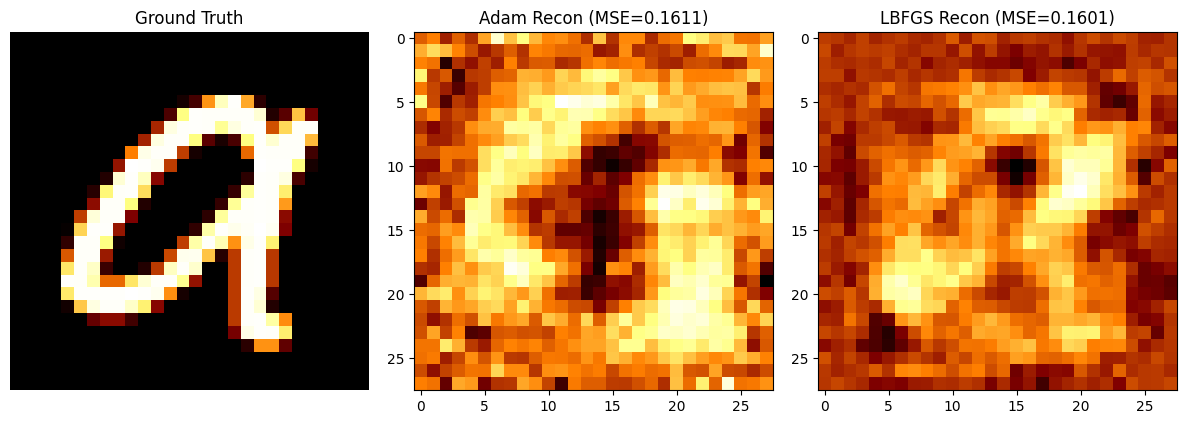

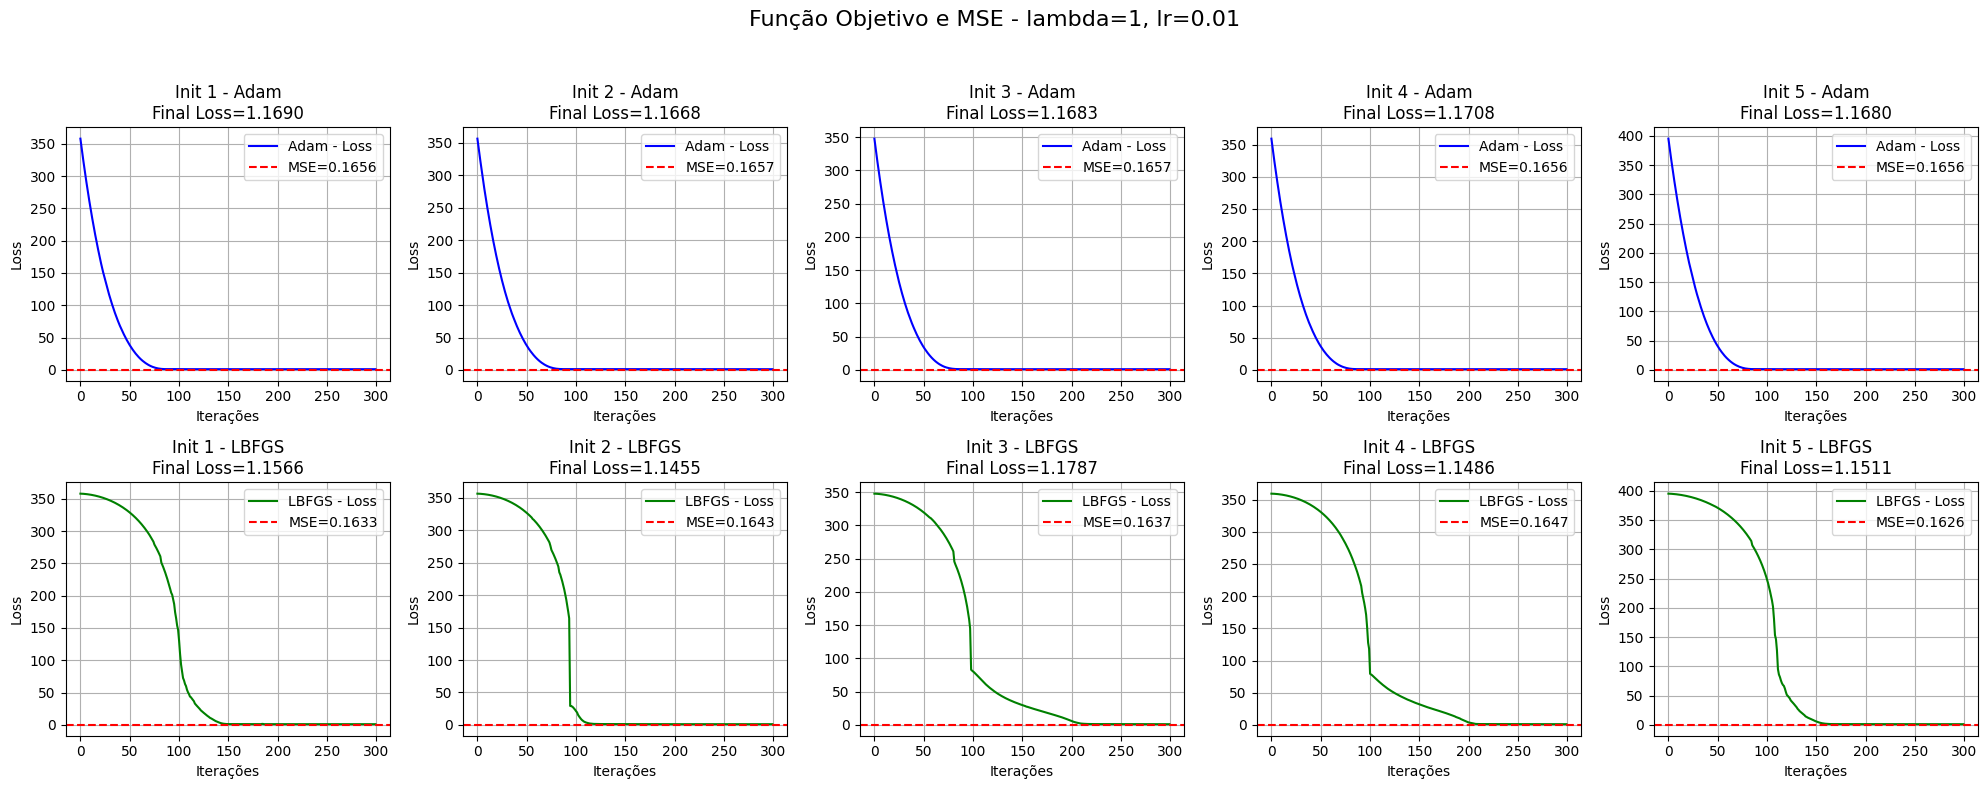

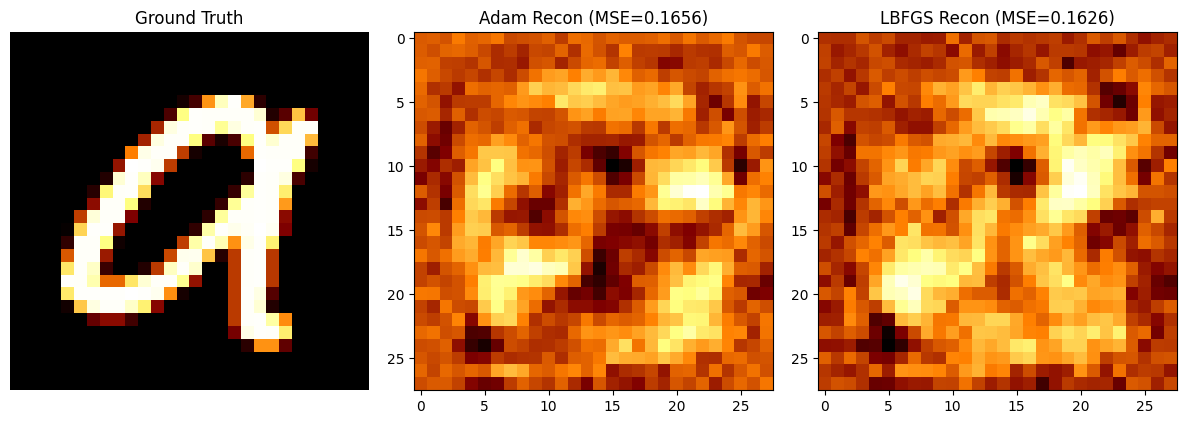

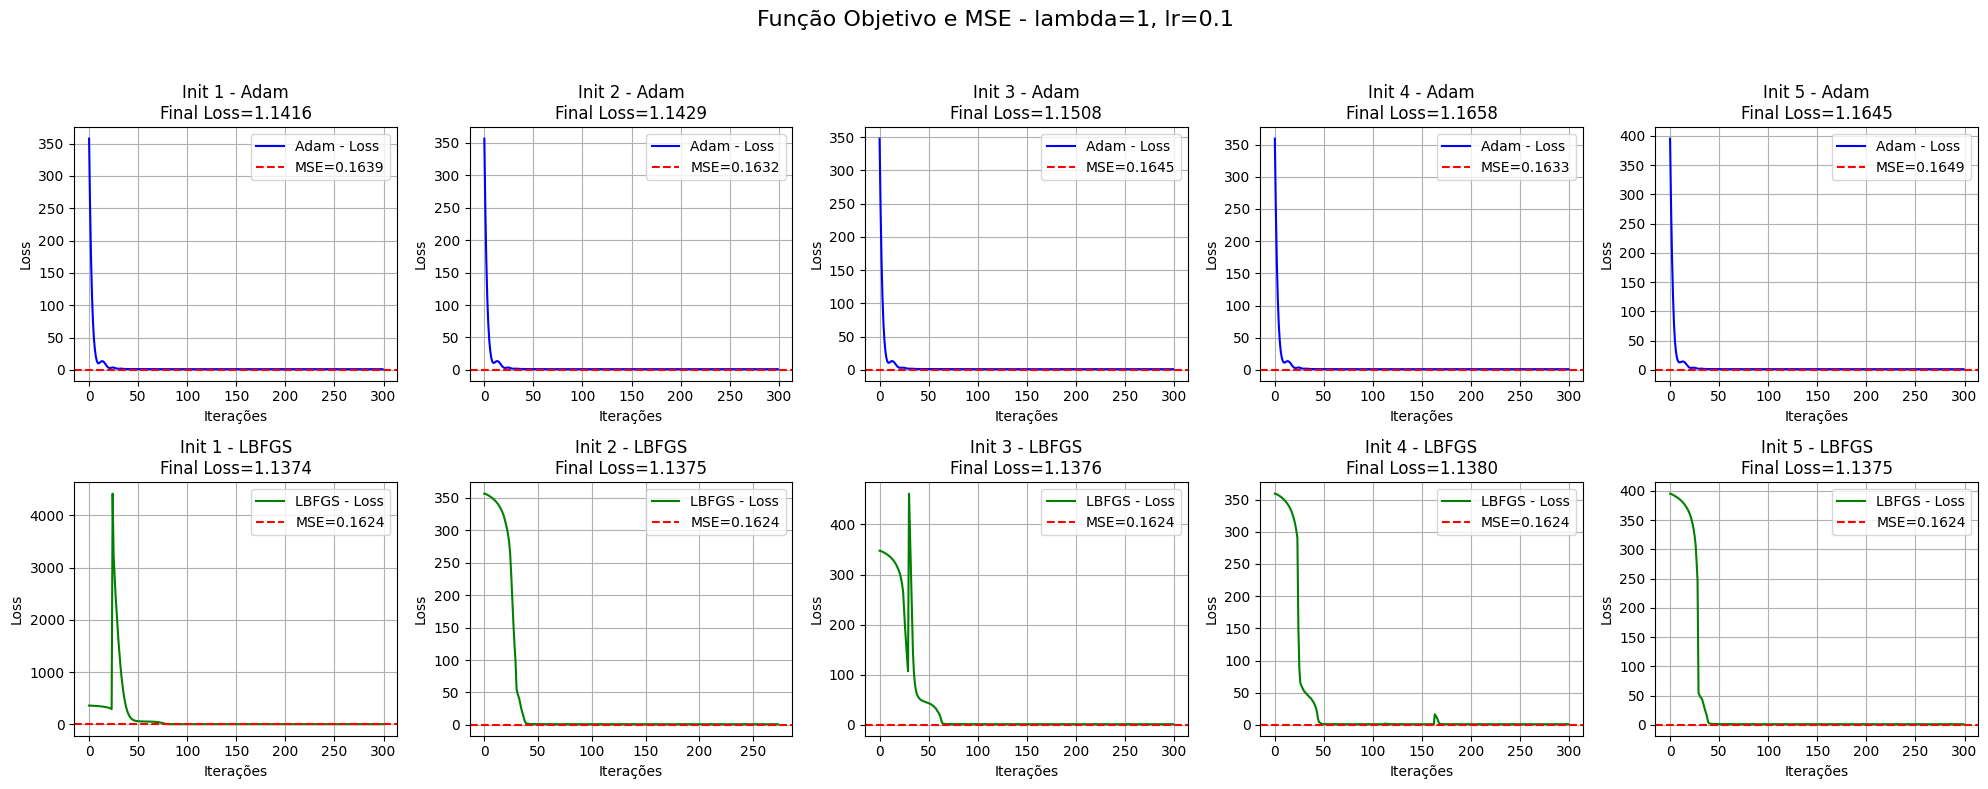

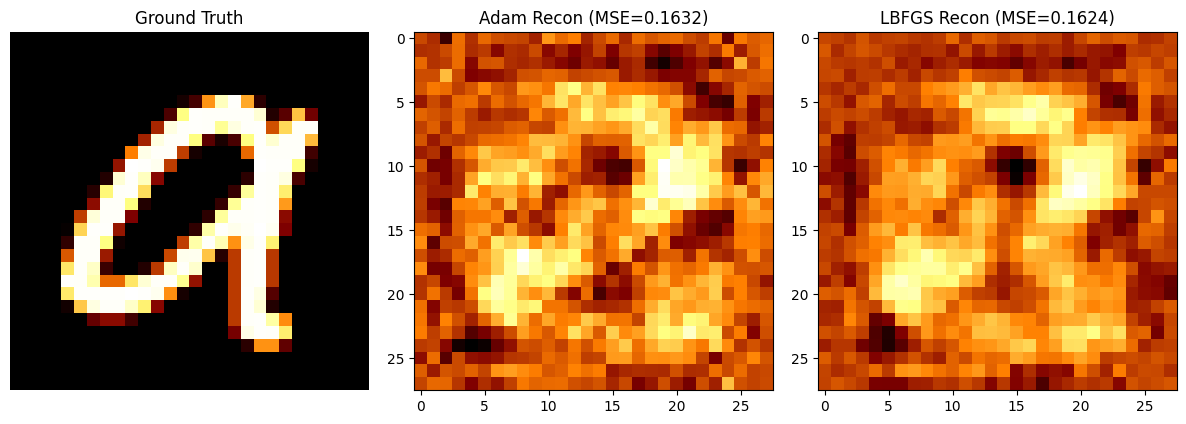

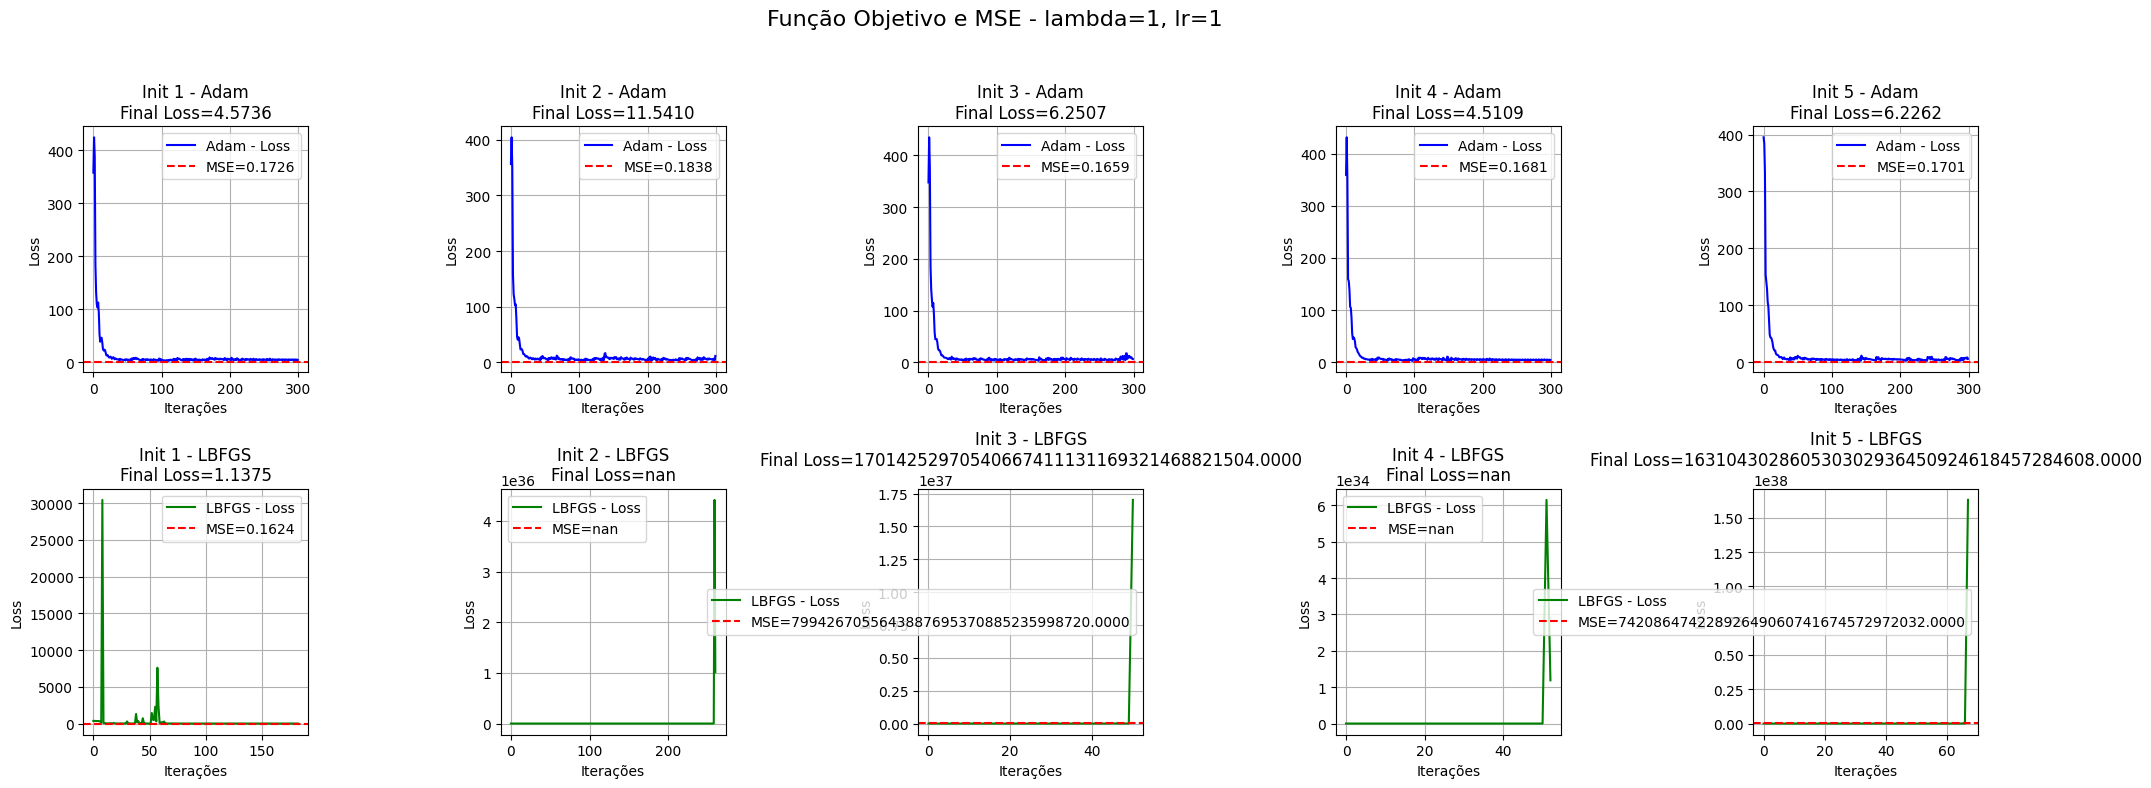

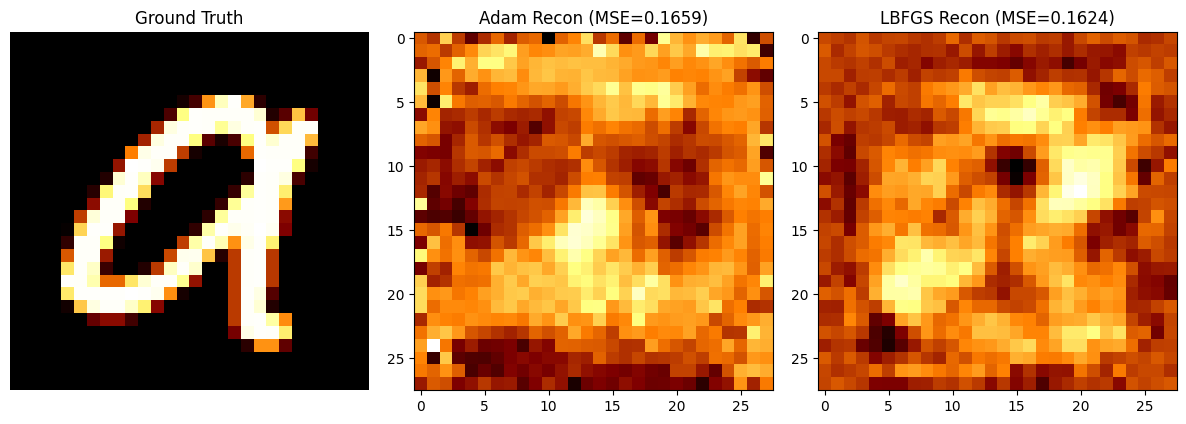

{'mse': 0.14150506258010864,
 'recon': tensor([[[[ 1.7516e-03, -3.4486e-04,  8.7727e-03, -9.5729e-03, -4.4192e-03,
            -1.9615e-03,  1.0081e-02,  2.0718e-05,  7.8963e-03,  4.5493e-03,
            -4.5681e-03,  2.2389e-03, -6.6590e-03, -2.0900e-03, -1.0458e-02,
            -8.9925e-03,  4.2431e-03,  2.8937e-03, -7.6546e-03,  5.1419e-04,
            -7.1595e-03, -1.8003e-03,  1.9378e-03, -5.7757e-03,  3.3908e-03,
             8.8579e-03, -1.8082e-04, -4.1253e-03],
           [ 8.2550e-03,  8.2848e-03,  6.2697e-03,  8.8482e-03, -6.9189e-04,
             1.3739e-02, -7.8826e-04,  4.0373e-03,  7.3321e-03,  1.1393e-02,
             1.6846e-02,  1.3035e-02,  5.7931e-03,  6.4397e-03,  1.0440e-02,
            -7.2483e-03,  5.7118e-03, -5.3111e-03, -9.0435e-03, -3.1716e-03,
             1.8933e-03,  8.4706e-03,  8.9535e-03,  1.7473e-02,  7.0202e-03,
            -1.4779e-03,  1.0356e-02, -1.1587e-03],
           [-7.0204e-04, -8.4999e-03, -1.3335e-02, -4.0360e-04, -6.4701e-04,
           

In [ ]:
values_lambda = [1e-2, 0.5, 1]        # Variacao nos valores de Lambda
values_learningRate = [0.01, 0.1, 1]  # Variacao nos valores de Taxa de Aprendizagem
all_results = []                      # Salva todos resultados

# Retira gradiente vazado e normaliza
x_gt, y_gt = sample_single(dataset, device)
g_star = compute_gradient(model, x_gt, y_gt)
g_star = g_star / (g_star.norm() + 1e-8)

# Varia valores dos parametros
for lamb in values_lambda:
  for lr in values_learningRate:

    # Armazena valores da f.o e MSE
    traces_adam = []
    mses_adam = []
    traces_lbfgs = []
    mses_lbfgs = []

    # Varia para 5 inicializacoes diferentes
    for init_seed in range(num_initializations):
      # Adam
      x_recon_a, y_recon_a, loss_a = reconstruct_single(
        model, g_star, device=device,
        lambda_reg=lamb, lr=lr,
        optimizer='adam', iters=300, seed=init_seed
      )
      mse_a = torch.mean((x_recon_a - x_gt.cpu()).pow(2)).item()
      traces_adam.append({'loss': loss_a, 'recon': x_recon_a})
      mses_adam.append(mse_a)

      # LBFGS
      x_recon_l, y_recon_l, loss_l = reconstruct_single(
        model, g_star, device=device,
        lambda_reg=lamb, lr=lr,
        optimizer='lbfgs', iters=300, seed=init_seed
      )
      mse_l = torch.mean((x_recon_l - x_gt.cpu()).pow(2)).item()
      traces_lbfgs.append({'loss': loss_l, 'recon': x_recon_l})
      mses_lbfgs.append(mse_l)

      # Adiciona o resultado à lista geral
      all_results.append({
          'mse': mse_l, 'recon': x_recon_l, 'optimizer': 'lbfgs',
          'lamb': lamb, 'lr': lr, 'seed': init_seed
      })

    # Plota curvas de perda e reconstrucoes
    plot_losses_and_mse(traces_adam, mses_adam, traces_lbfgs, mses_lbfgs, lamb, lr)
    plot_best_reconstructions(x_gt, traces_adam, mses_adam, traces_lbfgs, mses_lbfgs)

# Retorna melhor configuracao
get_best_configuration(all_results)